Group 3, PHYS243
<br>
Timothy Chuang
<br>
Daniel O'Connor
<br>
Jacqueline Duong
<br>
Gary Ku

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

import re
from textblob import TextBlob
from collections import defaultdict

import nltk
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.classify.util import accuracy as nltk_accuracy

import string
from string import punctuation
from gensim import corpora, models
from gensim.models import Word2Vec
string.punctuation

import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
import os

def load_reviews(folder_path):
    reviews = [] # empty list for the reviews
    ratings = os.path.basename(folder_path) # the folder name is the ratings i.e. ..reviews/1 is 1 star etc
    
    for filename in os.listdir(folder_path): # iterate thru all files in the folder
        filepath = os.path.join(folder_path, filename) 

        if os.path.isfile(filepath):
            with open(filepath, 'r', encoding='utf-8') as file:
                reviews.append({'review': file.read(), 'rating': rating})
                
    return pd.DataFrame(reviews)
    

In [3]:
all_dfs = [] # empty list

# cycle thru each folder -- ie 'Data/reviews/1 , Data/reviews/2 , etc.'
for rating in range(1, 6):
    df_temp = load_reviews(os.path.join('reviews', str(rating)))
    all_dfs.append(df_temp)

In [4]:
#Combine all the ratings and reviews into one df
df = pd.concat(all_dfs, ignore_index=True)

In [5]:
df.sample(5)

,review,rating
14271,thanks,4
17558,If you need a good fast charger for the car th...,5
20871,This card has been working just fine for me in...,5
18979,This was a very easy install I was completely ...,5
8529,"These are very average, nothing special to not...",3


Lets find the number of reviews per rating score

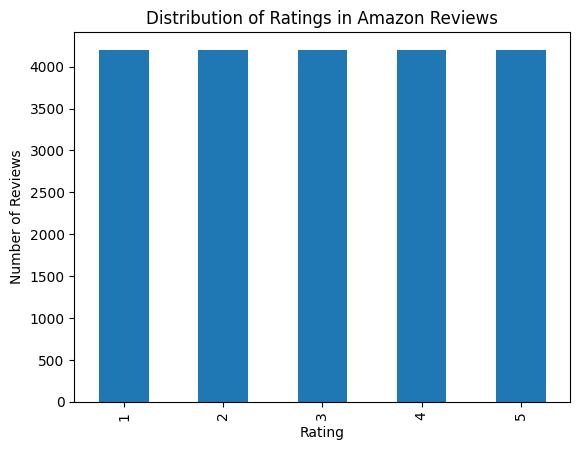

In [6]:
# number of reviews per rating score
df['rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Ratings in Amazon Reviews')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

We can see that the rating scores are relatively equal, but there might be duplicates in the data

In [7]:
print('Number of duplicates: ', df.duplicated().sum())
print('Percentage of Duplicates: ', df.duplicated().sum()/df.shape[0])

Number of duplicates:  14509
Percentage of Duplicates:  0.6909047619047619


Almost 70% of the dataset is duplicates! There are a very large number of duplicated reviews which pose a problem later on, especially with data leakage from the training set to the testing set. I suspect they were duplicated to artifically balance the classes (different review ratings). We will move forward without duplicates.

In [8]:
#An example of duplicates
duplicated_rows = df[df.duplicated(keep=False)]
print(duplicated_rows.sort_values(by='review').head(20))

                                                  review  rating
4457   "High Volume" cartridges...what a joke. With t...       2
4479   "High Volume" cartridges...what a joke. With t...       2
4501   "High Volume" cartridges...what a joke. With t...       2
4390   "High Volume" cartridges...what a joke. With t...       2
4346   "High Volume" cartridges...what a joke. With t...       2
4324   "High Volume" cartridges...what a joke. With t...       2
4523   "High Volume" cartridges...what a joke. With t...       2
4412   "High Volume" cartridges...what a joke. With t...       2
4435   "High Volume" cartridges...what a joke. With t...       2
4368   "High Volume" cartridges...what a joke. With t...       2
16504  "Kurdene S8 Deep Bass Sound Earbuds" is how th...       4
16471  "Kurdene S8 Deep Bass Sound Earbuds" is how th...       4
16484  "Kurdene S8 Deep Bass Sound Earbuds" is how th...       4
16457  "Kurdene S8 Deep Bass Sound Earbuds" is how th...       4
16510  "Kurdene S8 Deep B

# EDA & Preprocessing

### Dropping Duplicates / NA

In [9]:
#Drop duplicates, drop NA
clean_df = df.drop_duplicates()
clean_df.dropna(inplace=True)
clean_df.reset_index(drop=True, inplace=True)

C:\Users\Garymon\AppData\Local\Temp\ipykernel_14372\3968895453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.dropna(inplace=True)


In [10]:
clean_df.head()

,review,rating
0,I'll start by saying I barely write reviews. O...,1
1,SAMSUNG EVO Select Micro SD-Memory-Card + Adap...,1
2,Just received the cartridges and the yellow ra...,1
3,I've been using HP printers for a long time as...,1
4,These ink Cartridges work as they should becau...,1


In [11]:
# ~6500 rows of data
clean_df.shape

(6491, 2)

The clean dataset is notably smaller and doesn't maintain the same balance as before. However, every category is still reasonably represented.

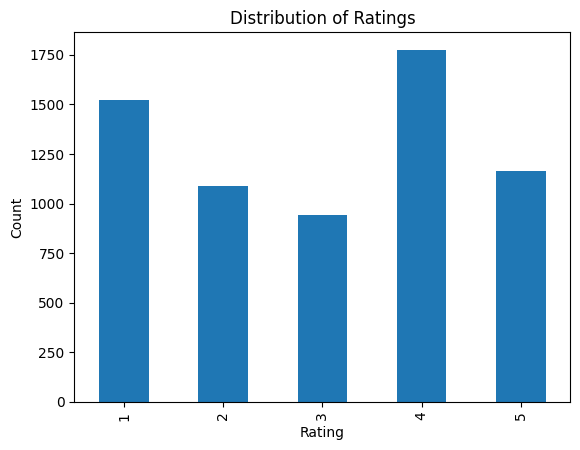

In [12]:
# distribution of clean dataset
clean_df['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

A quick look into two samples from each rating.

In [13]:
#display full content of reviews
pd.set_option('display.max_colwidth', None)

# getting 2 samples from each rating score
for rating in range(1, 6):
    sample = clean_df[clean_df['rating'] == rating].sample(2)
    print(sample)
    print('-'*80)  

                                                                                                                                                                                                                          review  \
970                                                                                                            I purchased this speaker last year. Don't waste your money. All it does is flash a red light and will not charge.   
108  It leaks all over my documents. And this is not the first time. I bought this product many many times and several of them were leaking. Not sure if it’s original toner but for this price the quality supposed to be good.   

     rating  
970       1  
108       1  
--------------------------------------------------------------------------------
                                                                                                                                                                                                

From this example I see there are some different languages in here. Let's try to filter to only English. We will use a function that will check if a review is in English

### Filter only English reviews 

In [14]:
from langdetect import detect, DetectorFactory

# Use random seed for reproducability
DetectorFactory.seed = 0

def is_english(text):
    try:
        # Return True if EN else flase
        return detect(text) == 'en' # True
    except:
        return False

In [15]:
# Filter df English reviews only
df_english_only = clean_df[clean_df['review'].apply(is_english)]

In [16]:
# number of non-english samples
print('Number of non-English samples: ', clean_df.shape[0] - df_english_only.shape[0])

Number of non-English samples:  135


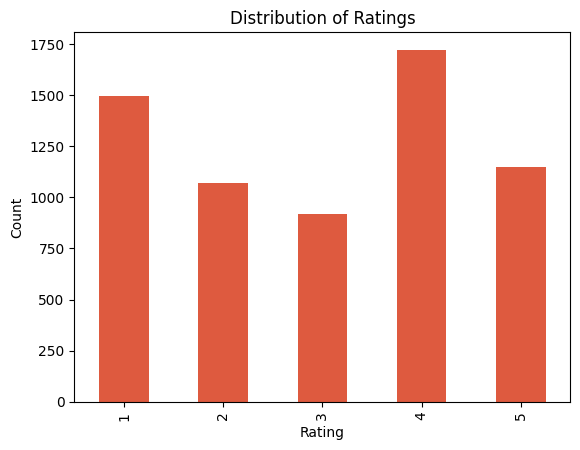

In [72]:
# distribution of clean dataset
df_english_only['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

### Sentiment Visualization 

Textblob assigns a poliarity score to each review which aims to gauge the sentiment.

In [17]:
def get_sentiment(review):
    blob = TextBlob(review)
    return blob.sentiment.polarity

In [18]:
eda_df_binary = df_english_only.copy()
eda_df = df_english_only.copy()

eda_df['sentiment'] = eda_df['review'].apply(get_sentiment)
eda_df_binary['sentiment'] = eda_df_binary['review'].apply(get_sentiment)

#Apply positive(1) is 4 or 5, neg is 1 or 2(0)
eda_df_binary['rating'] = eda_df_binary['rating'].apply(lambda x: 1 if x > 3 else 0)

In [19]:
eda_df.shape

(6356, 3)

Here, as expected the mean of the sentiment score rises throughout each rating. Notably though there is quite a bit of variance which will potentially be difficult for a model to distinguish sentiment through different classes. In the binary case (negative vs. positive) there is also a small difference in sentiment in the positive reviews.

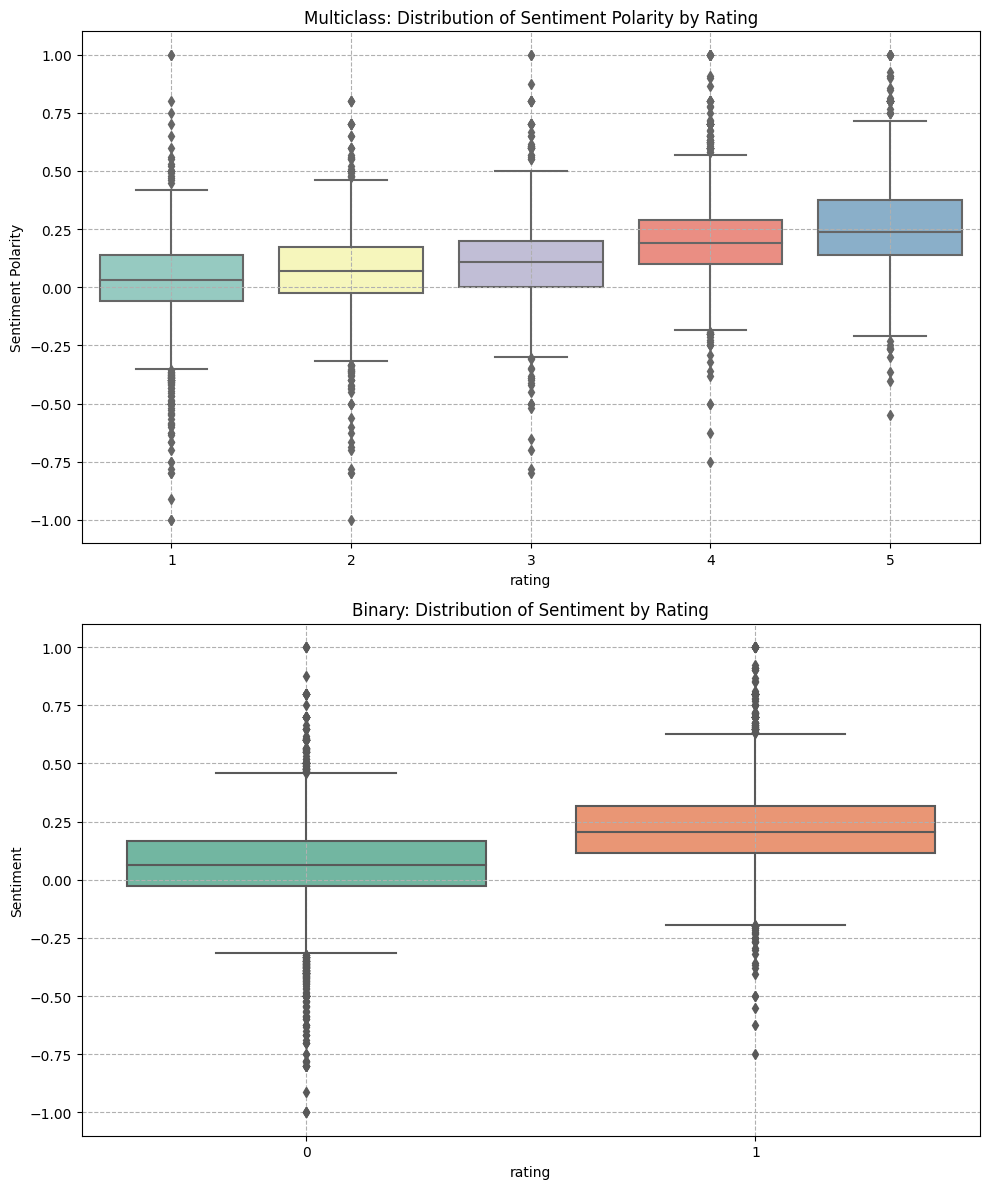

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

#all 5 sentiment values
sns.boxplot(x=eda_df['rating'], y=eda_df['sentiment'], palette="Set3", ax=axes[0])
axes[0].set_title('Multiclass: Distribution of Sentiment Polarity by Rating')
axes[0].grid(True, which='both', linestyle='--')
axes[0].set_ylabel('Sentiment Polarity')

#binary sentiment
sns.boxplot(x=eda_df_binary['rating'], y=eda_df_binary['sentiment'], palette="Set2", ax=axes[1])
axes[1].set_title('Binary: Distribution of Sentiment by Rating')
axes[1].grid(True, which='both', linestyle='--')
axes[1].set_ylabel('Sentiment')

plt.tight_layout()
plt.show()

Below shows the relationship between sentiment and binary rating. The rating is not as strong as one would anticipate.

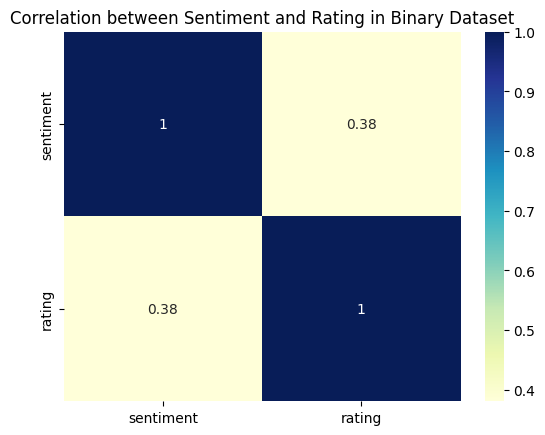

In [21]:
sns.heatmap(eda_df_binary[['sentiment', 'rating']].corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation between Sentiment and Rating in Binary Dataset')
plt.show()

In the binary classification task, the classes are fairly balanced.

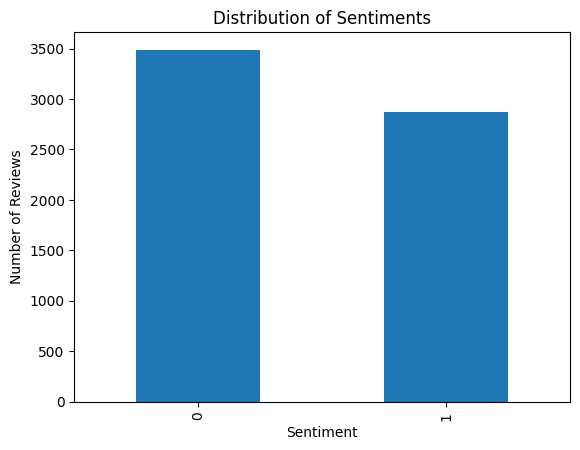

In [22]:
#plot binary distribution. 1 is positive, 0 is negative. 
eda_df_binary['rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

### Common Words 

Below we will look at some of the most common words for both positive and negative reviews. We will use CountVectorizer, which effectively turns the reviews into a matrix of token counts, with one token for each word. We are simply inspecting the raw counts of words (without stopwords, or common words. i.e. the, and, it, etc.).

In [23]:
#seperating out pos and neg reviews
positive_reviews =eda_df_binary[eda_df_binary['rating'] == 1]['review']
negative_reviews = eda_df_binary[eda_df_binary['rating'] == 0]['review']

In [24]:
positive_reviews

3554                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 When I first bought this item I had some trouble with amazon's shipping department. They failed to include this dongle along with my other two packages in one box. I don't think this was the seller's fault as they didn't combine the packages. I have a dell optiplex 9020 SFF PC and it does not have a USB C port like some other models do. I got a Logitech Brio 500 Webcam for christmas a

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

#instantiate count vectorizer with english stop words
countvec_pos = CountVectorizer(stop_words='english')
countvec_neg = CountVectorizer(stop_words='english')

#vectorize both pos and neg reviews
pos = countvec_pos.fit_transform(positive_reviews)
neg = countvec_neg.fit_transform(negative_reviews)

In [26]:
# create 2 df for each positive and negative words
pos_word_counts = pd.DataFrame(
    {"counts": pos.toarray().sum(axis=0)},
    index=countvec_pos.get_feature_names_out()
).sort_values("counts", ascending=False)

neg_word_counts = pd.DataFrame(
    {"counts": neg.toarray().sum(axis=0)},
    index=countvec_neg.get_feature_names_out()
).sort_values("counts", ascending=False)

Some quick observations: 
- `Just` is in the top 3 for both positive and negative. This makes sense as it is commonly used to 
- Lots of words appear frequently in both, some examples: `Great`, `Quality`, `Good`. My theory is `not` is a perhaps a stopword and we are only looking at single words, not n-grams or strings of words. i.e. `NOT Good Quality!` 


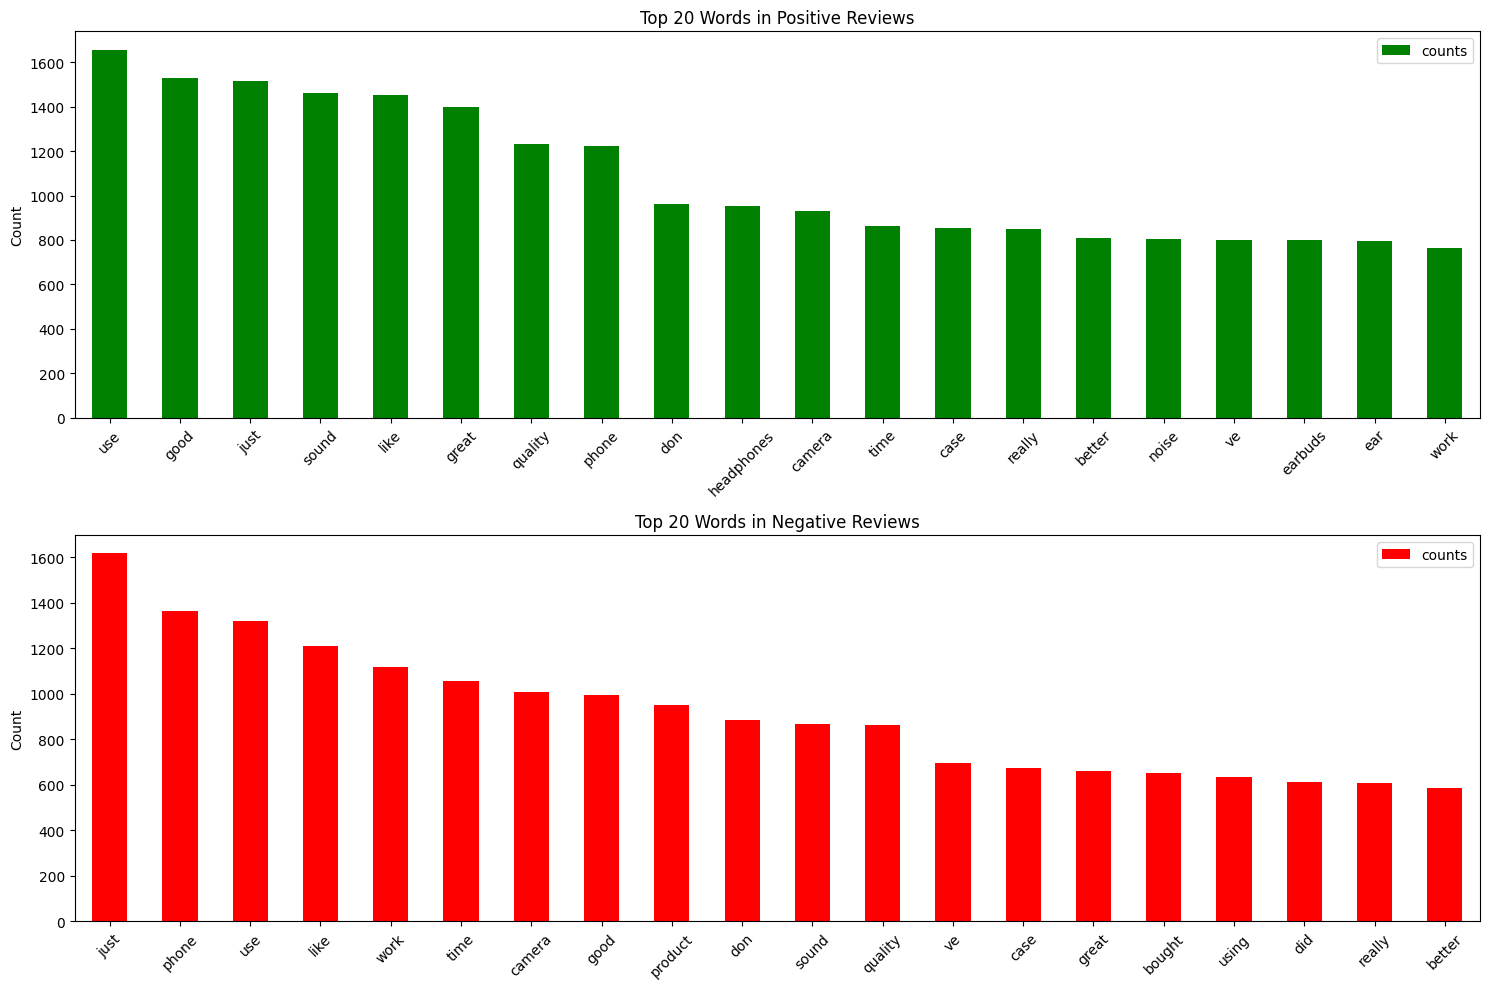

In [27]:
# Plotting for Positive Reviews
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
pos_word_counts.head(20).plot(kind='bar', ax=plt.gca(), color='green')
plt.title('Top 20 Words in Positive Reviews')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plotting for Negative Reviews
plt.subplot(2, 1, 2)
neg_word_counts.head(20).plot(kind='bar', ax=plt.gca(), color='red')
plt.title('Top 20 Words in Negative Reviews')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Word Vectorization 

Next we are going to see if we can cluster the reviews in 2-dimensional space to see if there is any natural spacing. To do this, it requires vectorizing each word, or token of a review. We used `Word2Vec`. This effectively turns each word into a multi-dimensional representation, such that words with similar meanings or used in similar contexts are closer in this multi-dimensional space. `Word2Vec` has been trained on massive amounts of text and has a good understanding of semantic relationships between words.

In [28]:
# first split the reviews into words, or tokens
tokenized_df = df_english_only.copy()
tokenized_df['tokenized_reviews'] = tokenized_df['review'].apply(lambda x: x.split())
sentences = tokenized_df['tokenized_reviews'].tolist()

In [29]:
tokenized_df.sample(1)

,review,rating,tokenized_reviews
5830,"I went ahead and splurged on these around 3 to 6 months ago after I stepped on my X3s in the dark and cracked the band mechanism. I do not regret my purchase at all; these cans produce such rich and full-bodied bass-enhanced sound that I can't leave a room in my house without bringing them with me.. in case I need awesome music for a bit.Funny story.. I thought the noise-canceling was just kind of mediocre this whole time, especially when I was flying back from visiting my parents and using them on a plane. The trick is to quickly press the second button toward the back on the left earpiece to activate noise-canceling. It was like the angels sang when I did that.. suddenly the music was so clear and rich, the plane noises virtually eliminated. Duh. So if you own these or are thinking about it, don't forget that tip!As I mentioned, I've owned the older X3 model for quite a few years now and loved them; these X5s are even better and I love them for all music listening occasions. They're a little bassier than the X3s, definitely a step further on that front. I happen to like bass (not muddied, just ""full"" and well-rounded), and these deliver. The highs and mids never seem to suffer either, though! A lot of it depends on fooling with your app's EQ settings, too. So don't be afraid to experiment!Great headphones and, if you have the money to splurge, they're worth it!♫/♥︎/♫",5,"[I, went, ahead, and, splurged, on, these, around, 3, to, 6, months, ago, after, I, stepped, on, my, X3s, in, the, dark, and, cracked, the, band, mechanism., I, do, not, regret, my, purchase, at, all;, these, cans, produce, such, rich, and, full-bodied, bass-enhanced, sound, that, I, can't, leave, a, room, in, my, house, without, bringing, them, with, me.., in, case, I, need, awesome, music, for, a, bit.Funny, story.., I, thought, the, noise-canceling, was, just, kind, of, mediocre, this, whole, time,, especially, when, I, was, flying, back, from, visiting, my, parents, and, using, them, on, a, plane., The, trick, is, to, ...]"


In [30]:
# Train Word2Vec
model = Word2Vec(sentences=tokenized_df['tokenized_reviews'], vector_size=100, window=5, min_count=1, workers=4)
model.train(tokenized_df['tokenized_reviews'], total_examples=model.corpus_count, epochs=10)

(6476872, 8344800)

Here is an example of `Word2Vec` successfully finding similar words within the trained vocabulary of the reviews. Next to each output word is the similiarity score. 

In [31]:
model.wv.most_similar('good', topn=10)

[('decent', 0.8378349542617798),
 ('great', 0.8044191598892212),
 ('bad', 0.6944881677627563),
 ('amazing', 0.6430219411849976),
 ('nice', 0.6344783902168274),
 ('good,', 0.6299625635147095),
 ('cheap', 0.6294461488723755),
 ('reasonable', 0.6276618838310242),
 ('solid', 0.6217330098152161),
 ('cool', 0.6081238389015198)]

In [32]:
def get_review_vector(review, model):
    # Initialize a list to store vectors
    vectors = []
    for word in review:
        try:
            vectors.append(model.wv[word])
        except KeyError:  # Word not in the model's vocabulary
            pass
    # Average the vectors for each review
    return np.mean(vectors, axis=0)

tokenized_df['review_vector'] = tokenized_df['tokenized_reviews'].apply(lambda x: get_review_vector(x, model))

In [33]:
from sklearn.manifold import TSNE

#Turn into array so TSNE can take
vectors = np.array(tokenized_df['review_vector'].tolist())


#TSNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Add to DataFrame for ease of use
tokenized_df['tsne_x'] = reduced_vectors[:, 0] 
tokenized_df['tsne_y'] = reduced_vectors[:, 1]

With the current embeddings, it appears that the data is not easily seperable. Below shows a very dense cluster. This could be due to:
- Overlap in semantic content. 
- The embeddings may not capture detailed meanings
- Inherent complexity of the way people write reviews and then subsequently give their scores.

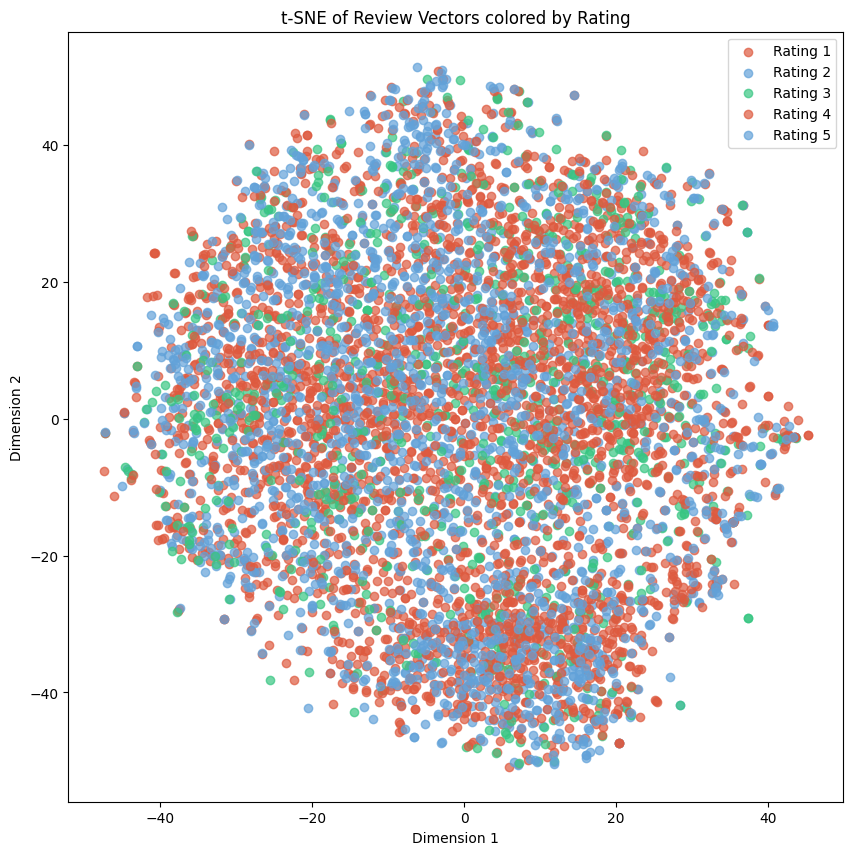

In [81]:
plt.figure(figsize=(10, 10))
for rating in tokenized_df['rating'].unique():
    subset = tokenized_df[tokenized_df['rating'] == rating]
    plt.scatter(subset['tsne_x'], subset['tsne_y'], label=f'Rating {rating}', alpha=0.7)

plt.legend()
plt.title('t-SNE of Review Vectors colored by Rating')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

### Good, Neutral, Bad

Now we try extending our classification to three classes, where scores of 1/2 = Bad, 3 = Neutral, 4/5 = Good

In [35]:
#Here we extend our classification to three classes, where scores of 1 & 2 return Bad, score = 3 returns Neutral, 
#scores 4 & 5 return good
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Bad'

In [36]:
#Creating a new column with the new rating applied
tokenized_df['good/neutral/bad'] = tokenized_df['rating'].apply(rating)

In [37]:
tokenized_df.sample(1)

,review,rating,tokenized_reviews,review_vector,tsne_x,tsne_y,good/neutral/bad
751,Decided on this brand because of many reviews but regretted it once I tried to install. There is not enough sticky residue to hold my phone without it peeling off.Used it in my GMC Sierra truck dash and window.,1,"[Decided, on, this, brand, because, of, many, reviews, but, regretted, it, once, I, tried, to, install., There, is, not, enough, sticky, residue, to, hold, my, phone, without, it, peeling, off.Used, it, in, my, GMC, Sierra, truck, dash, and, window.]","[0.39913285, -0.25877273, -0.5716416, -0.23098335, -0.0807953, -0.50347257, -0.15628083, 0.29346025, -0.7779545, 0.15567558, -0.68514615, -0.35230803, -1.2568321, -0.32492226, 0.21992199, -0.01861219, -0.1826233, 0.08999934, -0.5688352, -0.29637158, 0.46434212, 0.039553896, 0.17304578, -0.25135103, -0.6320535, 0.09328711, -0.11419911, 0.05307, 0.19818573, 0.54992455, 0.6354785, -0.24160591, 0.19813442, -0.2993775, 0.2639682, 0.45657137, 0.2752353, 0.9015765, -0.26943424, -0.055490162, 0.10285957, -0.18102261, -0.4552047, 0.5169109, 0.36668953, -0.06901598, 0.057362594, 0.33162913, 0.71262455, 0.16530803, -0.13381927, -0.13362163, 0.3499472, 0.0065729795, 0.26751572, 0.38700214, -0.091774315, -0.25970483, 0.17569558, 0.7030749, 0.19176865, 0.57290035, 0.73314923, -0.056222256, -0.38914338, 0.20817657, 0.5357256, 0.44907212, -0.5140375, -0.0729482, -0.5041254, -0.5790374, 0.45801932, 0.57001317, -0.06961683, 0.66813254, -0.533361, -0.14079973, -0.19318768, -0.37431479, 0.19616927, 0.19910127, -0.058265246, -0.11992029, 0.8135521, -0.3159179, -0.24647899, 1.4222094, 0.28021786, -0.0143948, 0.22378406, 0.39214662, 0.33487162, -0.0702258, 0.5966719, 0.23646103, 0.10114466, -0.5130859, 0.1905354, -0.49125665]",-27.667059,15.849969,Bad


### Sorting Number of Words By Category

We can calculate the number of words in each review and visualize the distribution of number of words against category

In [38]:
#calculate number of words in each review
sent_len = []
for sent in tokenized_df['review']:
    sent_len.append(len(word_tokenize(sent)))
tokenized_df['sent_len'] = sent_len
tokenized_df.head()

review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             I'll start by saying I barely write reviews. Only when something is really good or really bad. This product was the latter. It started off ok...nice looking frame. Very quick set-up. We purchased as a holiday gift for my mother (65 y/o and somewhat tech savy) who lives a plane ride away so we could surprise her with pictures of our family now and then. We really liked the email option. Our kids set-up the custom email address and it was somewhat inappropriate, so I reached out to customer service to see how to delete it and set-up another. It took a day or so, but they got back to me and reset

Now we can visualize the average number of words per category

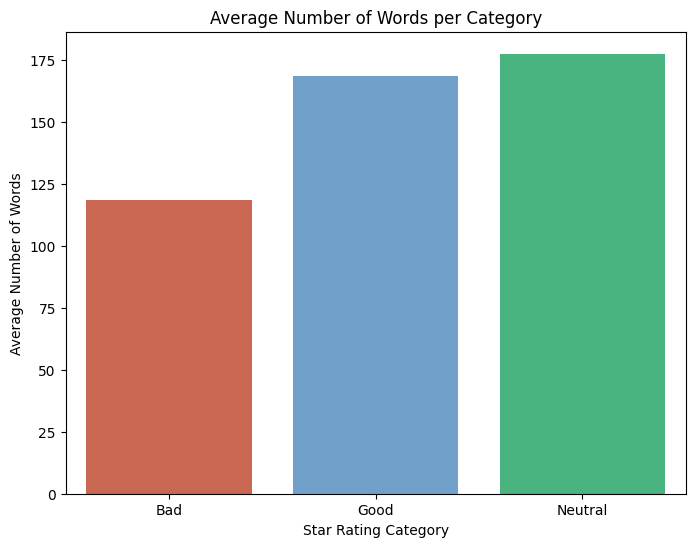

In [39]:
colors = ['#DE5A3F', '#62A2D9', '#38C682']
sns.set_palette(colors)
average_words_per_category = tokenized_df.groupby('good/neutral/bad')['sent_len'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=average_words_per_category.index, y=average_words_per_category.values)
plt.title("Average Number of Words per Category")
plt.xlabel("Star Rating Category")
plt.ylabel("Average Number of Words")
plt.show()

In [40]:
print(tokenized_df.groupby('rating').count())

        review  tokenized_reviews  review_vector  tsne_x  tsne_y  \
rating                                                             
1         1496               1496           1496    1496    1496   
2         1071               1071           1071    1071    1071   
3          920                920            920     920     920   
4         1721               1721           1721    1721    1721   
5         1148               1148           1148    1148    1148   

        good/neutral/bad  sent_len  
rating                              
1                   1496      1496  
2                   1071      1071  
3                    920       920  
4                   1721      1721  
5                   1148      1148  


### Lowercase Conversion, Punctuation Removal, Stopword Removal, Lemmatization 

 We can finish our preprocessing with lowercase conversion, removing punctuation, tokenizing, stopword removal and lemmatization

In [41]:
# Initialize NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Garymon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Garymon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Garymon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [43]:
# Preprocess and replace paragraphs in the dataset
for idx, row in tokenized_df.iterrows():
    paragraph = row['review']

    # Convert to lowercase
    paragraph = paragraph.lower()

    # Remove punctuation
    paragraph = paragraph.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    words = word_tokenize(paragraph)

    # Remove stop words and lemmatize
    filtered_words = []
    for word in words:
        if word not in stop_words:
            lemmatized_word = lemmatizer.lemmatize(word)
            filtered_words.append(lemmatized_word)

    preprocessed_paragraph = ' '.join(filtered_words)

    # Update the dataset with the preprocessed paragraph
    tokenized_df.at[idx, 'review'] = preprocessed_paragraph

In [44]:
tokenized_df.sample(1)

,review,rating,tokenized_reviews,review_vector,tsne_x,tsne_y,good/neutral/bad,sent_len
653,bought end november beginning february one charger worked going return realized threw half trash were…trash wish careful really deserve get money back never hated product one awful none work dont think worked longer month waste money even small amount 10 feel monumental didnt even work minute hardly think need take terrible product site,1,"[I, bought, these, at, the, very, end, of, November, and, here, it, is, the, very, beginning, of, February, and, not, one, of, these, chargers, has, worked., I, was, going, to, return, them, and, then, I, realized, I, threw, half, of, them, in, the, trash, because, they, were…trash., I, wish, I, had, been, more, careful, because, I, really, deserve, to, get, my, money, back., I, have, never, hated, a, product, more, than, this, one., It, is, awful,, none, of, them, work,, I, don't, think, any, of, them, worked, longer, than, a, month,, if, that., It, is, such, a, waste, of, money, ...]","[0.64849275, -0.45385867, -0.61476946, -0.42048946, 0.19834772, 0.34089866, 0.028807906, 0.53254205, -0.75926954, 0.24491504, -0.96188974, -0.34950462, -1.1609573, -0.25279766, 0.3402562, -0.15166254, -0.5258123, 0.08615668, -0.24195547, 0.014417043, 0.36052215, -0.12852018, 0.19587997, -0.3373293, -0.8684638, -0.021879185, 0.28542358, -0.005270326, 0.38938594, 0.44876814, 0.3566915, -0.53831977, 0.1741152, -0.22424261, 0.41484678, 0.63641894, -0.36379883, 0.6387517, -0.52662003, 0.16158475, 0.1243118, -0.42460394, -0.47868636, 0.84844965, 0.7300057, -0.09402182, -0.24516585, 0.19566205, 0.68918806, -0.09429493, 0.04145388, 0.06675027, 0.41982624, -0.32307583, 0.24717085, 0.60717505, -0.1603885, -0.67293966, 0.07987605, 0.35510665, 0.3464153, 0.33956385, 0.2528996, 0.060739916, -0.50280863, 0.45390972, 0.42893314, 0.45632967, -0.7173186, 0.2893215, -0.47252065, -0.6592521, 0.48927787, 0.81053317, -0.10549529, 0.8592374, 0.26686418, 0.1963492, -0.5175141, -0.73583347, -0.031152852, -0.0010703896, -0.048319772, 0.21525545, 0.46731597, -0.5534169, 0.08792484, 1.6684145, 0.26157326, -0.03271329, 0.5473867, 0.11960348, 0.5095369, -0.010979016, 0.5650923, 0.2526837, 0.048996672, -0.6227297, 0.0585887, -0.45842668]",-23.88265,-17.700068,Bad,145


# Modeling

In [45]:
#Create a separate binary rating column to be used in binary classification
tokenized_df['binaryrating'] = tokenized_df['rating'].apply(lambda x: 1 if x > 3 else 0)

In [46]:
data_prepped = tokenized_df.copy()

### Train-Test Split + Vectorization

In [47]:
X = data_prepped.copy()
y = data_prepped['rating'].copy()
y_binary = data_prepped['binaryrating'].copy()

In [48]:
#Multinomial Case
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.1, random_state=42)

#Binary Case
binary_train_data, binary_test_data, binary_train_labels, binary_test_labels = train_test_split(X, y_binary, test_size=0.1, random_state=42)

In [49]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=2048, ngram_range=(1, 3))

# Vectorize the training set
train_data_tfidf = vectorizer.fit_transform(train_data['review'])

#Transform the test set to make sure we use the same features as the training set
test_data_tfidf = vectorizer.transform(test_data['review'])

# Vectorize Binary training set
binary_train_data_tfidf = vectorizer.fit_transform(binary_train_data['review'])

#Transform the test set to make sure we use the same features as the training set
binary_test_data_tfidf = vectorizer.transform(binary_test_data['review'])

# Convert the TF-IDF vectors to a dense array for better readability
vectors_array = test_data_tfidf.toarray()
vectors_df = pd.DataFrame(vectors_array, columns=vectorizer.get_feature_names_out())

In [50]:
train_data.sample(1)

,review,rating,tokenized_reviews,review_vector,tsne_x,tsne_y,good/neutral/bad,sent_len,binaryrating
229,used plantronics headset two decade voip without issue replace last one saddened see ’ really make model anymore purchased one ear piece extremely bulky hard wear wear glass could get past real issue connectivity walk 5ft away put wall device repeatedly disconnect reconnects distance base something always look bought one bc long distance base able walk around plantronics even going outside building issue one horrible sit desk never move fine headset walk around want mobility away computer ’ buy headset,1,"[I, have, used, plantronics, headsets, for, two, decades, with, my, voip, without, issue., When, I, had, to, replace, my, last, one, I, was, saddened, to, see, that, they, don’t, really, make, that, model, anymore., So, I, purchased, this, one., The, ear, piece, is, extremely, bulky, and, hard, to, wear, if, you, wear, glasses., But, I, could, get, past, that., The, real, issue, is, the, connectivity., If, you, walk, 5ft, away, and, put, a, wall, between, you, and, the, device,, it, repeatedly, disconnects, and, reconnects., Distance, from, base, is, something, I, always, look, at, and, bought, this, one, b/c, of, the, ...]","[0.43626934, -0.31082523, -0.6291794, -0.42811117, 0.07924503, -0.123973414, 0.16202405, 0.4208613, -0.79986274, -0.19137353, -0.7924214, -0.46187693, -0.85175323, -0.059956122, 0.34736294, -0.30710316, 0.017155644, -0.073846936, -0.40385252, -0.057051174, 0.38223344, -0.06429149, 0.043536715, 0.050221853, -0.5147723, -0.08590619, -0.0883352, -0.12978753, 0.32493666, 0.15055357, 0.38329875, -0.27200466, 0.36794373, -0.29284933, 0.19842666, 0.5787483, -0.234216, 0.5911295, -0.5746088, -0.21278282, -0.12827002, -0.12137971, -0.28518808, 0.39804235, 0.59215695, -0.19118151, 0.14328651, 0.3428749, 0.51548266, 0.3418669, -0.14760885, 0.015220456, 0.16206856, -0.4899965, 0.48972458, 0.61337656, 0.021983184, -0.22664244, -0.021153804, 0.41803867, 0.36998653, 0.49754244, 0.44863242, 0.044951238, -0.7938054, 0.32671002, 0.19277743, 0.5677349, -0.22052363, 0.15258467, -0.3983419, -0.5934532, 0.5842685, 0.6085532, -0.065394536, 0.72422445, -0.07502275, 0.069955, -0.333624, -0.09048713, 0.51559746, 0.16032115, -0.295605, 0.5244348, 0.641793, -0.39343938, -0.051265728, 1.3001713, -0.025397623, 0.16805252, 0.3466257, 0.16363046, 0.7666482, -0.042936753, 0.6224454, 0.30614346, 0.109734036, -0.3865747, -0.30815616, -0.4271585]",-7.484263,5.428998,Bad,181,0


## Binary Classification Models

In [58]:
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore", category=FutureWarning)

# dictionary of models to run
models = {'Logistic Regression':LogisticRegression(),'KNN':KNeighborsClassifier(),
          'Random Forest':RandomForestClassifier(), 'XGB':GradientBoostingClassifier()}


for model_name, classifier in models.items():
    classifier.fit(binary_train_data_tfidf, binary_train_labels)
    predictions = classifier.predict(binary_test_data_tfidf)
    accuracy = accuracy_score(binary_test_labels,predictions)
    
    print(f"Model: {model_name}")
    print(f'Accuracy: {accuracy}')
    print("Classification Report:")
    print(classification_report(binary_test_labels, predictions))

Model: Logistic Regression
Accuracy: 0.779874213836478
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       355
           1       0.78      0.70      0.74       281

    accuracy                           0.78       636
   macro avg       0.78      0.77      0.77       636
weighted avg       0.78      0.78      0.78       636

Model: KNN
Accuracy: 0.6698113207547169
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       355
           1       0.67      0.51      0.58       281

    accuracy                           0.67       636
   macro avg       0.67      0.65      0.65       636
weighted avg       0.67      0.67      0.66       636

Model: Random Forest
Accuracy: 0.7421383647798742
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       355
           1       0.72

## Multinomial Classification Models

### SMOTE

In [111]:
smote = SMOTE(sampling_strategy='auto')  # Adjust the sampling strategy

In [112]:
smote_train_data, smote_train_labels = smote.fit_resample(train_data_tfidf, train_labels)

### Logistic Regression Model

In [113]:
# Initialize Logistic Regression model
logreg_model = LogisticRegression()

# Train the model
logreg_model.fit(smote_train_data, smote_train_labels)

# Make predictions on the test set
lr_predictions = logreg_model.predict(test_data_tfidf)

# Calculate CR
print(sklearn.metrics.classification_report(test_labels, lr_predictions))

              precision    recall  f1-score   support

           1       0.60      0.60      0.60       163
           2       0.30      0.30      0.30       105
           3       0.30      0.36      0.33        87
           4       0.53      0.47      0.49       154
           5       0.59      0.61      0.60       127

    accuracy                           0.49       636
   macro avg       0.47      0.47      0.47       636
weighted avg       0.49      0.49      0.49       636



C:\Users\Garymon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest Model

In [114]:
# Initialize Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=69, random_state=42)

# Train the Random Forest model
random_forest_model.fit(smote_train_data, smote_train_labels)

# Make predictions on the test set using Random Forest
rf_predictions = random_forest_model.predict(test_data_tfidf)

# Calculate CR
print(sklearn.metrics.classification_report(test_labels, rf_predictions))

              precision    recall  f1-score   support

           1       0.49      0.61      0.54       163
           2       0.20      0.12      0.15       105
           3       0.28      0.24      0.26        87
           4       0.46      0.54      0.50       154
           5       0.54      0.46      0.50       127

    accuracy                           0.43       636
   macro avg       0.39      0.40      0.39       636
weighted avg       0.41      0.43      0.42       636



<Figure size 10000x10000 with 0 Axes>

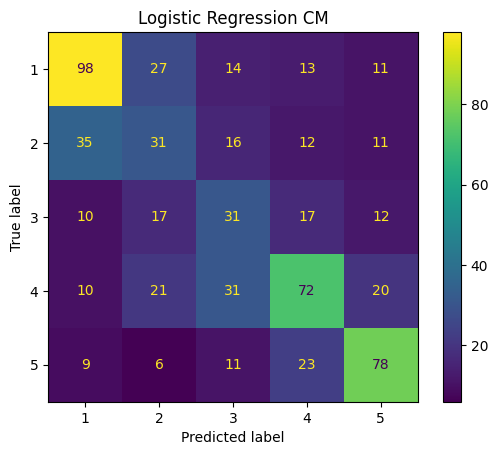

In [115]:
plt.figure(figsize = (100,100))
cm = sklearn.metrics.confusion_matrix(test_labels, lr_predictions, labels = logreg_model.classes_)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logreg_model.classes_)
cm_display.plot()
plt.title("Logistic Regression CM")
plt.show()

In [116]:
feature_importance = pd.DataFrame({'Feature': vectors_df.columns, 'Importance': random_forest_model.feature_importances_})

# Sort feature importance in descending order
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance.head(25))

         Feature  Importance
764        great    0.010930
750         good    0.007878
1986        work    0.007764
1029        love    0.007487
535         easy    0.006738
1193         one    0.006161
1482      return    0.005921
1110       month    0.005811
268       camera    0.005780
1894         use    0.005658
1363     product    0.004879
726          get    0.004762
1268       phone    0.004642
987         like    0.004609
2008       would    0.004566
1345       price    0.004459
1810        time    0.004441
566         even    0.004236
1951        well    0.004228
1108       money    0.004125
1989  work great    0.004125
1259     perfect    0.004096
1392     quality    0.003838
1144      needed    0.003684
225       bought    0.003565


### Gradient Boosting Model

In [ ]:
gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

#train the Gradient Boosting model
gbm_model.fit(smote_train_data, smote_train_labels)

#make predictions
gbm_predictions = gbm_model.predict(test_data_tfidf)

# Calculate CR
print(sklearn.metrics.classification_report(test_labels, gbm_predictions))

### Multinomial Naive Bayes Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

#train the Multinomial Naive Bayes model
nb_model.fit(smote_train_data, smote_train_labels)

#make predictions
nb_predictions = nb_model.predict(test_data_tfidf)

# Calculate CR
print(sklearn.metrics.classification_report(test_labels, nb_predictions))

### Multilayer Perceptron

In [68]:
#create the MLPClassifier with chosen hyperparameters
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

#train the MLP model on the training data
mlp_classifier.fit(train_data_tfidf, train_labels)

#use the trained model to make predictions
y_pred = mlp_classifier.predict(test_data_tfidf)

#evaluate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.41


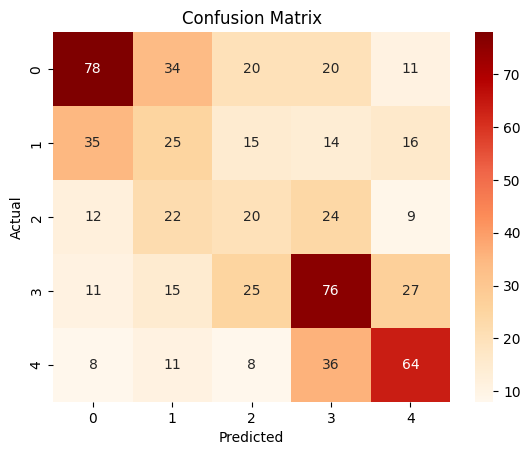

In [69]:
#confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(test_labels, y_pred)
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="OrRd")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [70]:
#MLP Classification Report
classification_report = metrics.classification_report(test_labels, y_pred)
print("Classification Report:\n", classification_report)

Classification Report:
               precision    recall  f1-score   support

           1       0.54      0.48      0.51       163
           2       0.23      0.24      0.24       105
           3       0.23      0.23      0.23        87
           4       0.45      0.49      0.47       154
           5       0.50      0.50      0.50       127

    accuracy                           0.41       636
   macro avg       0.39      0.39      0.39       636
weighted avg       0.42      0.41      0.41       636

